# Imports

In [1]:
import copy
import functools
import math
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import networkx as nx
from networkx.drawing.nx_agraph import graphviz_layout
import numpy as np
from IPython.core.display import display, HTML

import pandas as pd
import seaborn as sns
import sys


import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import torchvision.models as models
import time

In [2]:
display(HTML("<style>.container { width:100% !important; }</style>"))
np.set_printoptions(linewidth=150)
np.set_printoptions(edgeitems=10)

# Load Data

In [3]:
batch_size=64
image_shape = [32,32]
color_channels = 3
powers = [(2**x)*color_channels for x in range(3,20)]
print("Channel Progression:",powers)
data_shape = [batch_size,color_channels]+image_shape
classes=10
print("Data shape:",data_shape)
print("Classes:   ",classes)

train_data= datasets.CIFAR10('data10', 
                      train=True, 
                      download=True,
                      transform=transforms.Compose([
                          transforms.Resize(image_shape),
                          transforms.ToTensor(),
                          transforms.Normalize((0,), (1,))]
                      ))
test_data= datasets.CIFAR10('data10', 
                      train=False,
                      download=False,
                      transform=transforms.Compose([
                          transforms.Resize(image_shape),
                          transforms.ToTensor(),
                          transforms.Normalize((0,), (1,))]
                      ))
                      
train_loader = torch.utils.data.DataLoader(train_data,
                                           batch_size=batch_size, 
                                           shuffle=True)
test_loader  = torch.utils.data.DataLoader(test_data,
                                           batch_size=batch_size, 
                                           shuffle=False)

batches = len(train_loader)
print("Factors of",batches,"batches: ",[x for x in range(1,batches) if (batches/x)%1==0])

Channel Progression: [24, 48, 96, 192, 384, 768, 1536, 3072, 6144, 12288, 24576, 49152, 98304, 196608, 393216, 786432, 1572864]
Data shape: [64, 3, 32, 32]
Classes:    10
Files already downloaded and verified
Factors of 782 batches:  [1, 2, 17, 23, 34, 46, 391]


# Helpers

In [4]:
def padsize(s,k=3,d=1):
    pad = math.ceil((k*d-d+1-s)/2)
    return pad

def general_num_params(model):
    return sum([np.prod(p.size()) for p in filter(lambda p: p.requires_grad, model.parameters())])
    
def eq_string(n):
    return "="*n

# Operations

In [5]:
class Dilated_Conv(nn.Module):
    def __init__(self, C_in, C_out, kernel_size, stride, padding, dilation, affine=True):
        super(Dilated_Conv, self).__init__()
        self.op = nn.Sequential(
            nn.ReLU(inplace=False),
            nn.Conv2d(C_in, C_in, kernel_size=kernel_size, stride=stride, padding=padding, dilation=dilation, groups=C_in, bias=False),
            nn.Conv2d(C_in, C_out, kernel_size=1, padding=0, bias=False),
            nn.BatchNorm2d(C_out, affine=affine),
        )  
    def forward(self, x):
        return self.op(x)

class Single_Conv(nn.Module):
    def __init__(self, C_in, C_out, kernel_size, stride, padding, affine=True):
        super(Single_Conv, self).__init__()
        self.op = nn.Sequential(
          nn.ReLU(inplace=False),
          nn.Conv2d(C_in, C_in, kernel_size=kernel_size, stride=stride, padding=padding, groups=C_in, bias=False),
          nn.BatchNorm2d(C_out, affine=affine),
          )
    def forward(self, x):
        return self.op(x)

class xBy1_Conv(nn.Module):
    def __init__(self, C_in, C_out, kernel_size, stride, padding, affine=True):
        super(xBy1_Conv,self).__init__()
        self.op = nn.Sequential(
            nn.ReLU(inplace=False),
            nn.Conv2d(C_in, C_in, kernel_size=(1,kernel_size), stride=stride, padding=(0,padding), bias=False),
            nn.Conv2d(C_in, C_in, kernel_size=(kernel_size,1), padding=(padding,0), bias=False),
            nn.BatchNorm2d(C_in,affine=affine),
        )
    def forward(self,x):
        return self.op(x)

class Separable_Conv(nn.Module):  
    def __init__(self, C_in, C_out, kernel_size, stride, padding, affine=True):
        super(Separable_Conv, self).__init__()
        self.op = nn.Sequential(
            nn.ReLU(inplace=False),
            nn.Conv2d(C_in, C_in, kernel_size=kernel_size, stride=stride, padding=padding, groups=C_in, bias=False),
            nn.Conv2d(C_in, C_in, kernel_size=1, padding=0, bias=False),
            nn.BatchNorm2d(C_in, affine=affine),
            nn.ReLU(inplace=False),
            nn.Conv2d(C_in, C_in, kernel_size=kernel_size, stride=1, padding=padding, groups=C_in, bias=False),
            nn.Conv2d(C_in, C_in, kernel_size=1, padding=0, bias=False),
            nn.BatchNorm2d(C_out, affine=affine),
        )
        
    def forward(self, x):
        return self.op(x)

class Identity(nn.Module):
    def __init__(self,C_in,C_out,stride):
        super(Identity, self).__init__()
        if C_in==C_out:
            self.identity = nn.MaxPool2d(1,stride=stride)
        else:
            self.identity = nn.Conv2d(C_in, C_out, kernel_size=1,stride=stride)
    def forward(self, x):
        return self.identity(x)
        
class Zero(nn.Module):
    def __init__(self):
        super(Zero, self).__init__()
    def forward(self, x):
        return x.mul(0.)
    
class nn_View(nn.Module):
    def __init__(self):
        super(nn_View, self).__init__()
    def forward(self, x):
        return x.view(x.size()[0], -1)
    
class Classifier(nn.Module):
    def __init__(self,in_size,out_size):
        super(Classifier,self).__init__()
        self.in_size = in_size
        self.out_size= out_size
        
        self.op = nn.Sequential(
            nn_View(),
            nn.Dropout(),
            nn.Linear(in_size, in_size),
            nn.ReLU(inplace=True),
            nn.Linear(in_size, out_size),
            nn.Softmax(dim=1)
        )
        
    def forward(self,x):
        return self.op(x)
    
    def get_param_counts(self):
        return [general_num_params(op) for op in self.op]
    
    def __repr__(self):
        params = self.get_param_counts()
        out = "{} CLASSIFIER {}\n".format(eq_string(48),eq_string(48))
        out+= "nn_View:    {:<6} -> {:<6} ({:,} params)\n".format(self.in_size,self.in_size,  params[0])
        out+= "Dropout:    {:<6} -> {:<6} ({:,} params)\n".format(self.in_size,self.in_size,  params[1])
        out+= "Linear:     {:<6} -> {:<6} ({:,} params)\n".format(self.in_size,self.in_size,  params[2])
        out+= "ReLU:       {:<6} -> {:<6} ({:,} params)\n".format(self.in_size,self.in_size,  params[3])
        out+= "Linear:     {:<6} -> {:<6} ({:,} params)\n".format(self.in_size,self.out_size, params[4])
        out+= "Softmax:    {:<6} -> {:<6} ({:,} params)\n".format(self.out_size,self.out_size,params[5])
        return out

# Op Dict

In [6]:
commons = {
    'zero'               : Zero(),
    'identity'           : lambda C_in,stride          : Identity(C_in,C_in,           stride=stride),
    'double_channel'     : lambda C_in,stride          : Identity(C_in,C_in*2,         stride=stride),
    'halve_channel'      : lambda C_in,stride          : Identity(C_in,int(C_in*.5),   stride=stride),
    'avg_pool_3x3'       : lambda C_in,stride          : nn.AvgPool2d(3,               stride=stride, padding=padsize(s=stride), count_include_pad=False),
    'max_pool_3x3'       : lambda C_in,stride          : nn.MaxPool2d(3,               stride=stride, padding=padsize(s=stride)),
    'max_pool_5x5'       : lambda C_in,stride          : nn.MaxPool2d(5,               stride=stride, padding=padsize(s=stride,k=5)),
    'max_pool_7x7'       : lambda C_in,stride          : nn.MaxPool2d(7,               stride=stride, padding=padsize(s=stride,k=7)),
    '1x7_7x1_conv'       : lambda C_in,stride          : xBy1_Conv(C_in,C_in,7,        stride=stride, padding=padsize(s=stride,k=7)),
    '1x3_3x1_conv'       : lambda C_in,stride          : xBy1_Conv(C_in,C_in,3,        stride=stride, padding=padsize(s=stride)),
    'dil_conv_3x3'       : lambda C_in,stride          : Dilated_Conv(C_in, C_in, 3,   stride=stride, padding=padsize(s=stride,d=2), dilation=2),
    'conv_1x1'           : lambda C_in,stride          : Single_Conv(C_in, C_in, 1,    stride=stride, padding=padsize(s=stride,k=1)),
    'conv_3x3'           : lambda C_in,stride          : Single_Conv(C_in, C_in, 3,    stride=stride, padding=padsize(s=stride)),
    'sep_conv_3x3'       : lambda C_in,stride          : Separable_Conv(C_in, C_in, 3, stride=stride, padding=padsize(s=stride)),
    'sep_conv_5x5'       : lambda C_in,stride          : Separable_Conv(C_in, C_in, 5, stride=stride, padding=padsize(s=stride,k=5)),
    'sep_conv_7x7'       : lambda C_in,stride          : Separable_Conv(C_in, C_in, 7, stride=stride, padding=padsize(s=stride,k=7)),
}

padder = lambda C_in,C_out: Identity(C_in,C_out,stride=1)
idx_to_op=dict(enumerate(list(commons.keys())))
op_to_idx={op: idx for idx,op in idx_to_op.items()}
idx_to_op

{0: 'zero',
 1: 'identity',
 2: 'double_channel',
 3: 'halve_channel',
 4: 'avg_pool_3x3',
 5: 'max_pool_3x3',
 6: 'max_pool_5x5',
 7: 'max_pool_7x7',
 8: '1x7_7x1_conv',
 9: '1x3_3x1_conv',
 10: 'dil_conv_3x3',
 11: 'conv_1x1',
 12: 'conv_3x3',
 13: 'sep_conv_3x3',
 14: 'sep_conv_5x5',
 15: 'sep_conv_7x7'}

# Graph Edge Class

In [7]:
class Edge(nn.Module):
    def __init__(self,target,op):
        super(Edge, self).__init__()
    
        #edge attributes
        self.target      = target
        self.op          = op
        
        #forward functionality
        self.op_function = None
        self.padder      = lambda x: x
        
        #bookkeeping
        self.in_dim      = None
        self.out_dim     = None
        self.out         = None
    
    def forward(self,x):  
        x=self.padder(x)
        return self.op_function(x)
    
    def get_num_params(self):
        return general_num_params(self)
    
    def __str__(self):
        return self.__repr__()
    
    def __repr__(self):
        return "{:<18} -> {:<30} -> {:<18} to Node {} ({:,} params)".format(str(self.in_dim),self.op,str(self.out_dim),self.target.name,self.get_num_params())

# Graph Node Class

In [8]:
class Node(nn.Module):
    def __init__(self,name,dim=None):
        super(Node, self).__init__()
        
        #node attributes
        self.name=name
        self.dim = dim
        
        #node connections
        self.cnx = []
        self.ins  = []
        self.out = None
        
    def add_cnx(self,cnx,o_pos,t_pos):        
        #===DIMENSION MODIFICATION======================================
        in_channels=self.dim[1]
        
        #double channels if node receives cell input
        if o_pos==0:
            post_pad_channels=[x for x in powers if x>in_channels][0]
            cnx.padder = padder(in_channels,post_pad_channels)
        else:
            post_pad_channels = in_channels
        
        #halve spatial dimensions if node sends to output
        stride = 2 if t_pos==1 else 1
         
        #correct target channels if operation is channel modification
        if 'channel' in cnx.op:
            op_scaler = 2 if 'double' in cnx.op else .5
        else:
            op_scaler = 1
        post_op_channels=int(post_pad_channels*op_scaler)

        #===Intercept channel modifications if they are incompatible with target node
        if cnx.target.dim is not None:
            tgt_channels = cnx.target.dim[1]
            
            if tgt_channels!=post_op_channels:
                
                cnx.padder=padder(in_channels,int(tgt_channels/op_scaler))
                post_pad_channels = int(tgt_channels/op_scaler)
                post_op_channels  = tgt_channels
        
        
        #===CONNECTION SETTING==========================================
        #set attributes for connection
        
        cnx.op_function = commons[cnx.op](post_pad_channels,stride=stride)
        cnx.in_dim = self.dim
        cnx.out_dim = [self.dim[0],
                         post_op_channels,
                         int(self.dim[2]/stride),
                         int(self.dim[3]/stride)]
        if in_channels==post_pad_channels:
            cnx.op="{:<15} (by {}, {}----->{}-op->{})".format(cnx.op,stride,in_channels,post_pad_channels,post_op_channels)
        else:
            cnx.op="{:<15} (by {}, {}-pad->{}-op->{})".format(cnx.op,stride,in_channels,post_pad_channels,post_op_channels)
        
        #===SANITY CHECKING=============================================
        #make sure tensors are of right dimensionality
        if cnx.target.dim == None or cnx.target.dim == cnx.out_dim:
            cnx.target.dim = cnx.out_dim
        else:
            raise ValueError("Dimension mismatch from {} to {}: Target Dim {} vs Edge Dim {}".format(
                self.name,
                cnx.target.name,
                cnx.target.dim,
                cnx.out_dim))
        
        self.cnx.append(cnx)
        
    def forward(self,x=None,verbose=False):
        #if cell connects to first node, pass in input
        if self.ins == []:
            self.ins = [x]
        
        if verbose: print("=== Node ",self.name,"===")
        if verbose: print("Node Inputs:",[x.shape for x in self.ins])
        
        #add all input tensors together
        self.out = sum(self.ins)
        
        #clear memory of inputs (to avoid "retain-graph=True error")
        self.ins=[]
        
        #pass data through subsequent connections and set node output
        for cnx in self.cnx:
            if verbose: print("{}->{} via {}: {}->".format(self.name,cnx.target.name,cnx.op,self.out.shape),end="")
            cnx.out = cnx(self.out)
            cnx.target.ins.append(cnx.out)
            if verbose: print("{}".format(cnx.out.shape))
        return self.out
        
    def __repr__(self):
        out = ""
        out+="{} Node {} {}\n".format(eq_string(4),self.name,eq_string(4))
        if len(self.cnx) == 0:
            out+="{:<18} -> out\n".format(str(self.dim))
        else:
            for cnx in self.cnx:
                out+=str(cnx)+"\n"
        return out


# Cell Class

In [9]:
class Cell(nn.Module):
    def __init__(self,in_dim,matrix,reduce=False,verbose=False,to_probe=None):
        super(Cell, self).__init__()
        self.in_dim = in_dim
        self.nodes = nn.ModuleList()
        
        #create nodes
        for node in range(matrix.shape[0]):
            if node==0:
                self.nodes += [Node(0,in_dim)]
            else:
                self.nodes += [Node(node)]
        
        #create edge parameters
        self.edges = nn.ModuleList()
        matrix_width = matrix.shape[1]
        edgeQueue = list(zip(*matrix.nonzero()))
        
        #create edges and connect them to origin and target nodes
        for origin,target in edgeQueue:
            op = idx_to_op[int(matrix[origin,target])]            
            if verbose:
                print(origin,target,op)
            new_edge = Edge(target=self.nodes[target],op=op)
            self.nodes[origin].add_cnx(new_edge,o_pos=origin/(matrix_width-1),t_pos=target/(matrix_width-1))
            self.edges.append(new_edge)
            
    def get_out_dim(self):
        #find output dimension of cell
        return self.nodes[-1].dim
    
    def get_upscale(self):
        #determine scaling ratios of cell
        filters =  self.nodes[-1].dim[1]/self.in_dim[1]
        dims = self.nodes[-1].dim[2]/self.in_dim[2]
        return filters,dims
    
    def forward(self,x,verbose):
        for i,node in enumerate(self.nodes):
            if i==0:
                #if node is the input node in cell, pass in cell input
                out=node.forward(x,verbose=verbose)
            else:
                #otherwise, nodes will receive input tensors from prior nodes
                out=node.forward(verbose=verbose)
        return out

    def __repr__(self):
        out = ""
        for i,node in enumerate(self.nodes):
            out+=str(node)
        return out

# Network Class

In [10]:
class Net(nn.Module):
    def __init__(self,cells,matrix,in_dim,classes):
        super(Net, self).__init__()
        self.matrix=matrix
        self.cells = nn.ModuleList()
           
        #create and join cells
        for cell in range(cells):
            old_dim = in_dim
            new_cell = Cell(in_dim,matrix)
            in_dim = new_cell.get_out_dim()
            
            #make sure cells scale tensors correctly
            if cells>1 and old_dim[1]>=in_dim[1] and old_dim[2]<=in_dim[2]:
                raise ValueError("Cell doesn't properly scale")
                
            self.cells.append(new_cell)
        
        #append linear classifier after all cells
        self.classifier = Classifier(int(np.prod(in_dim[1:])),classes)
        
    #find scaling ratio of component cell
    def get_cell_upscale(self):
        return [cell.get_upscale() for cell in self.cells]
                
    def get_num_params(self):
        return general_num_params(self)
            
    def forward(self,x,verbose):
        #pass data through cells
        for cell in self.cells:
            x = cell(x,verbose)
        #pass data through classifier
        x = self.classifier(x)
        if verbose:
            sys.exit()
        return x

    def minimal_print(self):
        out = "{} NETWORK CELL {}\n".format(eq_string(50),eq_string(50))
        return out+str(self.cells[0])
        
    def __repr__(self):
        out = ""
        for i,cell in enumerate(self.cells):
            out+="{} CELL {} {}\n".format(eq_string(50),i,eq_string(50))
            out+=str(cell)
            if not all_cells:
                break
            
        out+=str(self.classifier)
        out+="{}\nTOTAL PARAMS: {:,}\n".format(eq_string(108),self.get_num_params())
        return out  

# Train/Test Loops

In [11]:
#single epoch train function
def train(model, device, train_loader, criterion, optimizer, epoch, validate=False,verbose=False):
    if not validate: print()
    ims = []
    for batch_idx, (data, target) in enumerate(train_loader):
        
        data, target = data.to(device), target.to(device)        
        
        optimizer.zero_grad()
        output = model.forward(data,verbose)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        
        if batch_idx % 2 == 0:
            if not validate:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    epoch, batch_idx * len(data), len(train_loader.dataset),
                    100. * batch_idx / len(train_loader), loss.item()),
                     end="\n",flush=True)
        if validate: return True

#single epoch validation function
def test(model, device, test_loader):
    model.eval()
    test_loss= 0
    corrects = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            
            output=model.forward(data,verbose=False)
            test_loss += F.nll_loss(output, target, size_average=False).item() # sum up batch loss
            pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
            corrects += pred.eq(target.view_as(pred)).sum().item()
            
    test_loss = np.round(test_loss/len(test_loader.dataset),2)
                
    print('\nTest Loss',test_loss,'Corrects',corrects,"/",len(test_loader.dataset))
    return test_loss
    
#run n epochs of the training and validation
def full_model_test(model,epochs):
    device = torch.device("cpu")
    lr=.05
    momentum=.9
    losses= []
    optimizer = optim.SGD(model.parameters(),lr=.025,momentum=.9,weight_decay=3e-4)
    criterion = nn.CrossEntropyLoss()
    
    for epoch in range(epochs):
        train(model,device, train_loader, criterion, optimizer, epoch)
        losses.append(test(model,device,test_loader))
    return -min(losses)

#run a single batch through the model and perform a single optimization step, just to make sure everything works ok
def model_validate(model,verbose):
    if verbose:
        print("Validating model...",end="")
    device = torch.device("cpu")
    lr=.05
    momentum=.9
    losses= []
    optimizer = optim.SGD(model.parameters(),lr=.025,momentum=.9,weight_decay=3e-4)
    criterion = nn.CrossEntropyLoss()
    
    try:
        valid=train(model,device, train_loader, criterion, optimizer, epoch=0, validate=True,verbose=False)
        if verbose: print("[SUCCESS]")
    except KeyboardInterrupt:
        raise
    except:
        print("\n{} ERROR: PRINTING MODEL DEBUGGING {}".format(eq_string(50),eq_string(50)))
        print(model)
        show_matrix(model.matrix,"Failed Model")
        train(model,device, train_loader, criterion, optimizer, epoch=0, validate=True,verbose=True)
        

# Graph Generator/Utilities

In [12]:
def gen_cell(nodes,sparsity_thresh):
    #generate random cell matrix with $nodes nodes
    #connects node_i to node_j with probabilty $sparsity thresh
    nn = np.zeros((nodes,nodes))
    for i in range(nodes):
        for j in range(nodes):
            if j>i:
                num = np.random.randint(1,13) if np.random.rand() > sparsity_thresh else 0
                nn[i,j]=num
            if j>0 and i==nodes-1 and all(nn[:,j]==0):
                nn[0,j]=1
        if i<nodes-1 and all(nn[i,]==0):
            nn[i,-1]=1
    return nn

def build_matrix(pairs):
    #build cell matrix from connectivity pairs
    #input [(0,1,3),(1,2,4)] means node0->node1 via op 3, node1->node2 via op4, etc
    
    nodes = np.max([[x[0],x[1]] for x in pairs])+1
    matrix = np.zeros([nodes,nodes])
    for origin,target,function in pairs:
        if type(function)==str:
            matrix[origin,target]=op_to_idx[function]
        else:
            matrix[origin,target]=function
    return matrix
     
def show_matrix(matrix,name):
    #plot cell DAG
    g = nx.DiGraph()
    for origin,target in zip(*matrix.nonzero()):
        g.add_edge(origin,target,function=idx_to_op[int(matrix[origin,target])])
    pos=graphviz_layout(g, prog='dot')
    
    size=matrix.shape[0]
    plt.figure(figsize=(size*1.5,size*1.5))
    nx.draw_networkx(g,pos)
    edge_labels = nx.get_edge_attributes(g,'function')
    nx.draw_networkx_edge_labels(g,pos=pos,edge_labels=edge_labels,arrows=True)
    plt.title(name)
    plt.show()

def stack_matrix(matrix,cells): 
    dim = matrix.shape[0]
    out = np.zeros([dim*cells-1]*2)
    for cell in range(cells):
        shift = 0 if cell==0 else 1
        a,b=cell*(dim-shift),cell*(dim-shift)+dim
        out[a:b,a:b]=matrix
    return out
    
def cubify(matrix):
    #one hot each element in cell matrix (returns matrix of shape [n_nodes,n_nodes,n_ops])
    out = []
    ops = len(idx_to_op)-1
    for i in range(matrix.shape[0]):
        for j in range(matrix.shape[1]):
            if j>i:
                row = np.zeros(ops)
                op = int(matrix[i,j])
                if op!=0:
                    row[op-1]=1
                out+= list(row)
    return np.array(out)

# View Op List For Reference

In [13]:
idx_to_op

{0: 'zero',
 1: 'identity',
 2: 'double_channel',
 3: 'halve_channel',
 4: 'avg_pool_3x3',
 5: 'max_pool_3x3',
 6: 'max_pool_5x5',
 7: 'max_pool_7x7',
 8: '1x7_7x1_conv',
 9: '1x3_3x1_conv',
 10: 'dil_conv_3x3',
 11: 'conv_1x1',
 12: 'conv_3x3',
 13: 'sep_conv_3x3',
 14: 'sep_conv_5x5',
 15: 'sep_conv_7x7'}

# Define Some Common Cells

In [14]:
vggNet = build_matrix([
    [0,1,'conv_3x3'],
    [1,2,'conv_3x3'],
    [2,3,'conv_3x3'],
    [3,4,'max_pool_3x3']
])

resNet = build_matrix([
    [0,1,'conv_3x3'],
    [0,2,'identity'],
    [1,2,'conv_3x3'],
    [2,3,'conv_3x3'],
    [2,4,'identity'],
    [3,4,'conv_3x3'],
    [4,5,'max_pool_3x3']
])

resNeXt = build_matrix([
    [0,1,'halve_channel'],
    [1,2,'sep_conv_3x3'],
    [2,3,'double_channel'],
    [0,3,'identity'],
])

inception = build_matrix([
    [0,4,'conv_1x1'],
    [0,1,'conv_1x1'],
    [1,4,'sep_conv_3x3'],
    [0,2,'conv_1x1'],
    [2,4,'sep_conv_5x5'],
    [0,3,'max_pool_3x3'],
    [3,4,'conv_1x1'],
])

# Show Stacked Cells

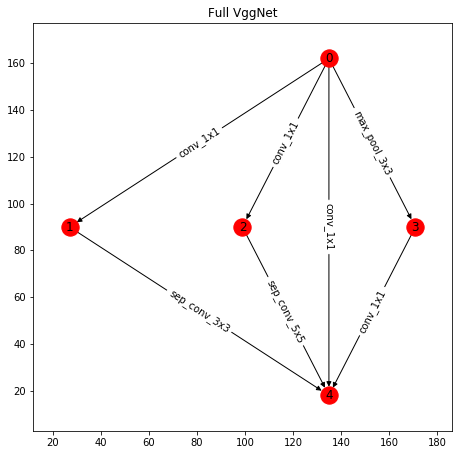

In [15]:
stacked=stack_matrix(inception,5)
show_matrix(inception,"Full VggNet")

# Generate model from matrix and run

In [16]:
#generate and display model, then validate that it runs correctly 
def gen_and_validate(cell,name,cell_count=None,verbose=True,keep_model=True):
    if verbose: print(cell)
    if verbose: show_matrix(cell,name)

    #initialize and display model
    cell_count = math.floor(math.log(32,2)) if cell_count is None else cell_count
    model = Net(cells=cell_count,matrix=cell,in_dim=data_shape,classes=classes)
    scales = model.get_cell_upscale()[-1]
    params = model.get_num_params()
    
    if scales[0]>2:
        print("Incorrect scaling ({}), skipping".format(scales))
        return params
    
    if verbose: print("Cell Scaling Factors:",scales)
    if verbose: print("Network Parameters: {:,}".format(params))
    print(model.minimal_print())

    #validate
    model_validate(model,verbose=verbose)
    
    if keep_model:
        return model
    else:
        return params

# Test 100 Random Cells
(to check graph construction logic, make sure tensors are always compatible, etc)

In [17]:
params = []

if 1:
    for i in range(100):
        print(i)
        
        #generate random cell
        rand_cell = gen_cell(7,sparsity_thresh=.5)
        params.append(gen_and_validate(rand_cell,"Random Cell",verbose=False,keep_model=False))

0
================================================== NETWORK CELL ==================================================
==== Node 0 ====
[64, 3, 32, 32]    -> identity        (by 1, 3-pad->24-op->24) -> [64, 24, 32, 32]   to Node 1 (96 params)
[64, 3, 32, 32]    -> conv_1x1        (by 1, 3-pad->24-op->24) -> [64, 24, 32, 32]   to Node 2 (168 params)
[64, 3, 32, 32]    -> halve_channel   (by 1, 3-pad->24-op->12) -> [64, 12, 32, 32]   to Node 3 (396 params)
[64, 3, 32, 32]    -> identity        (by 1, 3-pad->24-op->24) -> [64, 24, 32, 32]   to Node 4 (96 params)
[64, 3, 32, 32]    -> max_pool_7x7    (by 1, 3-pad->24-op->24) -> [64, 24, 32, 32]   to Node 5 (96 params)
[64, 3, 32, 32]    -> max_pool_5x5    (by 2, 3-pad->24-op->24) -> [64, 24, 16, 16]   to Node 6 (96 params)
==== Node 1 ====
[64, 24, 32, 32]   -> identity        (by 2, 24----->24-op->24) -> [64, 24, 16, 16]   to Node 6 (0 params)
==== Node 2 ====
[64, 24, 32, 32]   -> halve_channel   (by 1, 24----->24-op->12) -> [64, 12, 32, 3

KeyboardInterrupt: 

In [ ]:
n= len(params)
data = pd.DataFrame({'Model':np.arange(n),'e^n Parameters':np.log(params)})
sns.scatterplot(x='Model',y='e^n Parameters',data=data)

# Visualize and Run a Random Cell

In [ ]:
#generate and display random connectivity matrix and DAG
#cell = gen_cell(10,sparsity_thresh=.5)
#gen_and_validate(rand_cell,"Random Cell",cell_count=1,keep_model=False,verbose=True)

# Visualize and run pre-defined blocks

In [ ]:
gen_and_validate(inception,"Inception",keep_model=False)
gen_and_validate(resNet,"Resnet",keep_model=False)